# 1. Imports

In [7]:
from datetime import datetime
timestr = datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")

In [8]:
print(timestr)

2023-07-12-18h57m05s


In [8]:
datetime.now()

In [9]:
datetime

In [2]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import optim

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.masks import construct_round_rfrr_template

from sklearn.model_selection import train_test_split

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.file_handling import save_as_fits

# 2. Load the data

In [3]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [4]:
# Background subtraction
psf_template_data = psf_template_data - np.median(psf_template_data)
psf_template_data[psf_template_data< 0] = 0

# 3. Add a fake planet

In [5]:
#config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0188b.json"

In [6]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0117a.json"

In [7]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0071a.json"

In [8]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0142b.json"

In [9]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0363f.json"

In [10]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [11]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 0.00039810717055349735,
 'separation': 6.300000000000001,
 'planet_position': [59.3, 53.0, 6.300000000000001, 0.0],
 'exp_id': '0117a'}

In [12]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [14]:
# This noise model was only trained on half of the images
X_train = data_with_fake_planet[0::2]
anlges_train = raw_angles[0::2]
X_test = data_with_fake_planet[1::2]
anlges_test = raw_angles[1::2]

In [15]:
X_train.shape

(34666, 107, 107)

# 4. Fine-tuning

## 4.1 Load a pre-trained noise model

Note: the noise model was trained on the data without any fake planet. This is something we want to change for the final experiments!

In [16]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/"
                       "implementation_tests/test_model_trained_fp64.pkl")
s4_noise = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


## 4.2 move everything to the GPU

In [17]:
s4_noise = s4_noise.float()
s4_noise = s4_noise.to(0)

In [18]:
science_data_torch = torch.from_numpy(X_train).float()
science_data_torch = science_data_torch.to(0)

## 4.3 compute the residual without fine-tuning

In [19]:
residual_sequence, _ = s4_noise.predict(science_data_torch)

In [20]:
residual_sequence = residual_sequence.cpu().numpy()

In [21]:
# re-center around the median (not the mean)
residual_sequence -= np.median(residual_sequence, axis=0)

In [22]:
residual_before_fine_tuning = combine_residual_stack(
    residual_stack=residual_sequence,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)["Median_Residuals"]

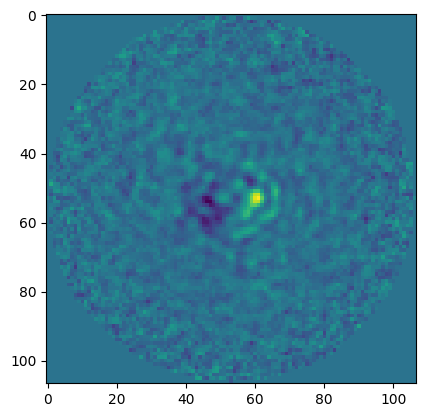

In [23]:
plt.imshow(residual_before_fine_tuning)

## 4.4 create planet model for fine-tuning

In [24]:
# Create a planet model
s4_planet_model = S4Planet(
    data_image_size=X_train.shape[-1],
    psf_template=psf_template_data,
    convolve_second=True,
    inner_mask_radius=0,
    use_up_sample=1)

In [25]:
# setup planet model for training
s4_planet_model.setup_for_training(
    all_angles=anlges_train,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

In [26]:
s4_planet_model = s4_planet_model.to(0)

## 4.5 run fine-tuning

In [27]:
#s4_noise.betas_raw.requires_grad = False

In [28]:
# The index list is needed to get all planet frames during fine-tuning. 
planet_model_idx = torch.from_numpy(
    np.arange(science_data_torch.shape[0]))

In [29]:
optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3,)

In [30]:
# 3.) Setup the normalization
X_mu = torch.mean(science_data_torch, axis=0)
X_std = torch.std(science_data_torch, axis=0)

# 4.) get the current normalized data
X_norm = (science_data_torch - X_mu) / X_std
science_norm_flatten = X_norm.view(
    X_norm.shape[0], -1)

noise_estimate_const = s4_noise(science_norm_flatten)

  0%|▊                                                                                                                                                                      | 1/200 [00:02<06:40,  2.01s/it]

0.34534645080566406
0.34534940123558044


  2%|██▌                                                                                                                                                                    | 3/200 [00:04<05:12,  1.58s/it]

0.34534648060798645


  2%|███▎                                                                                                                                                                   | 4/200 [00:06<05:01,  1.54s/it]

0.34534794092178345


  2%|████▏                                                                                                                                                                  | 5/200 [00:07<04:54,  1.51s/it]

0.3453463315963745


  3%|█████                                                                                                                                                                  | 6/200 [00:09<04:49,  1.49s/it]

0.3453447222709656


  4%|█████▊                                                                                                                                                                 | 7/200 [00:10<04:46,  1.49s/it]

0.3453439772129059


  4%|██████▋                                                                                                                                                                | 8/200 [00:12<04:43,  1.48s/it]

0.3453439176082611


  4%|███████▌                                                                                                                                                               | 9/200 [00:13<04:41,  1.47s/it]

0.34534379839897156
0.3453432619571686


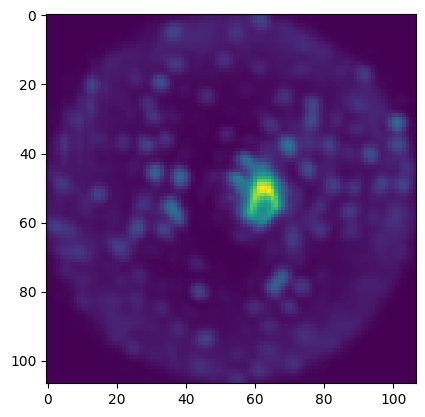

  6%|█████████▏                                                                                                                                                            | 11/200 [00:16<04:42,  1.49s/it]

0.3453426957130432


  6%|█████████▉                                                                                                                                                            | 12/200 [00:18<04:38,  1.48s/it]

0.34534236788749695
0.3453422486782074


  7%|███████████▌                                                                                                                                                          | 14/200 [00:21<04:33,  1.47s/it]

0.3453421890735626


  8%|████████████▍                                                                                                                                                         | 15/200 [00:22<04:31,  1.47s/it]

0.3453419804573059


  8%|█████████████▎                                                                                                                                                        | 16/200 [00:24<04:29,  1.46s/it]

0.3453417420387268


  8%|██████████████                                                                                                                                                        | 17/200 [00:25<04:27,  1.46s/it]

0.3453415334224701


  9%|██████████████▉                                                                                                                                                       | 18/200 [00:26<04:25,  1.46s/it]

0.34534141421318054


 10%|███████████████▊                                                                                                                                                      | 19/200 [00:28<04:24,  1.46s/it]

0.345341295003891
0.34534117579460144


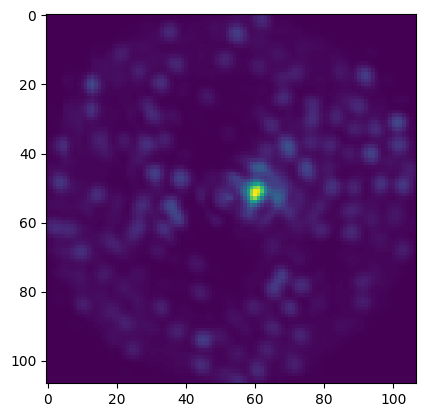

 10%|█████████████████▍                                                                                                                                                    | 21/200 [00:31<04:25,  1.48s/it]

0.3453410863876343


 11%|██████████████████▎                                                                                                                                                   | 22/200 [00:32<04:22,  1.48s/it]

0.3453409969806671


 12%|███████████████████                                                                                                                                                   | 23/200 [00:34<04:20,  1.47s/it]

0.34534093737602234
0.3453408479690552


 12%|████████████████████▊                                                                                                                                                 | 25/200 [00:37<04:16,  1.46s/it]

0.345340758562088


 13%|█████████████████████▌                                                                                                                                                | 26/200 [00:38<04:14,  1.46s/it]

0.34534069895744324


 14%|██████████████████████▍                                                                                                                                               | 27/200 [00:40<04:12,  1.46s/it]

0.34534069895744324


 14%|███████████████████████▏                                                                                                                                              | 28/200 [00:41<04:11,  1.46s/it]

0.3453406095504761


 14%|████████████████████████                                                                                                                                              | 29/200 [00:43<04:09,  1.46s/it]

0.3453405797481537
0.3453405201435089


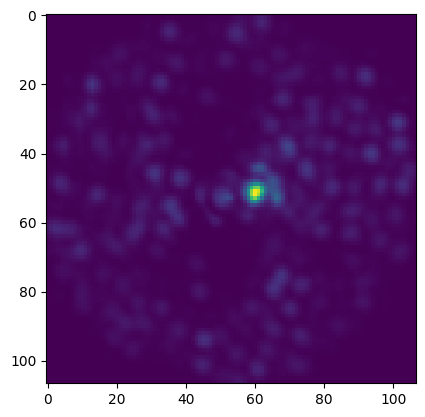

 16%|█████████████████████████▋                                                                                                                                            | 31/200 [00:46<04:10,  1.49s/it]

0.3453404903411865


 16%|██████████████████████████▌                                                                                                                                           | 32/200 [00:47<04:08,  1.48s/it]

0.34534043073654175


 16%|██████████████████████████▌                                                                                                                                           | 32/200 [00:49<04:17,  1.53s/it]


KeyboardInterrupt: 

In [31]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    
    # 1.) Get the current planet signal estimate
    planet_signal = s4_planet_model.forward(planet_model_idx)
    
    # 2.) Get the current data without the planet
    #data_no_planet = science_data_torch - planet_signal.squeeze().detach()
    
    # 3.) Setup the normalization
    #X_mu = torch.mean(data_no_planet, axis=0)
    #X_std = torch.std(data_no_planet, axis=0)
    
    # 4.) get the current normalized data
    #X_norm = (science_data_torch - X_mu) / X_std
    planet_signal_norm = planet_signal / X_std
    
    # 5.) reshape everything 
    planet_signal_norm = planet_signal_norm.view(
        science_data_torch.shape[0], -1)

    
    # 6.) run the forward path
    P_hat_N = s4_noise(planet_signal_norm)
    P_hat_N[P_hat_N>0] = 0
    
    noise_estimate = noise_estimate_const - P_hat_N

    # 7.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm
    
    # 8.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    loss_reg = (s4_noise.betas_raw**2).mean()

    # 9.) Backward 
    loss = loss_recon + loss_reg * s4_noise.lambda_reg
    loss.backward()

    optimizer.step()

    # 10.) Print the loss terms
    losses_recon.append(loss_recon.item())
    print(loss_recon.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = (planet_signal / X_std).detach()[-1]
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()

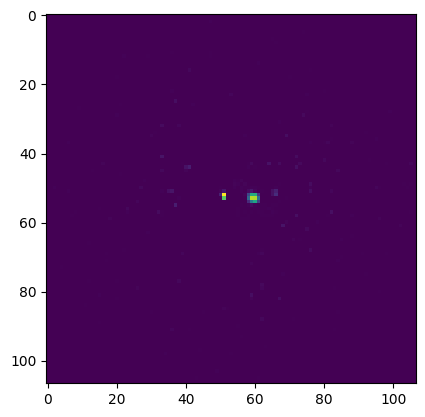

In [36]:
plt.imshow(s4_planet_model.get_planet_signal().detach()[0].cpu().numpy())

In [40]:
s4_noise.compute_betas()
betas=s4_noise.prev_betas.detach().cpu()

In [55]:
beta_frame = np.abs(betas[6500].reshape(107, 107))

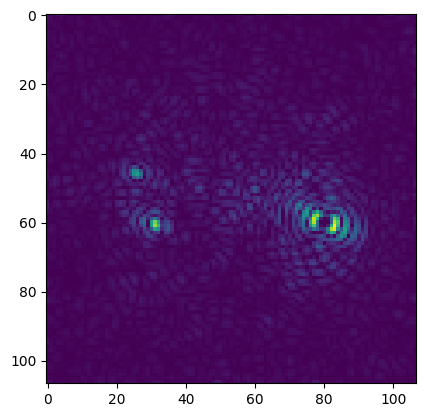

In [56]:
plt.imshow(beta_frame)

In [ ]:
plt.plot(losses_recon)
plt.yscale("log")

In [243]:
# 1.) Get the current planet signal estimate
planet_signal = s4_planet_model.forward(planet_model_idx)

# 2.) Get the current data without the planet
data_no_planet = science_data_torch - planet_signal.squeeze().detach()

# 3.) Setup the normalization
X_mu = torch.mean(data_no_planet, axis=0)
X_std = torch.std(data_no_planet, axis=0)

# 4.) get the current normalized data
X_norm = (science_data_torch - X_mu) / X_std
X_no_planet = (science_data_torch - planet_signal.squeeze() - X_mu) / X_std
    
# 5.) reshape everything 
science_norm_flatten = X_norm.view(
    X_norm.shape[0], -1)

science_norm_flatten_no_planet = X_no_planet.view(
    X_norm.shape[0], -1)

noise_estimate = s4_noise(science_norm_flatten_no_planet)

In [244]:
# compute the residual
residual_squence = science_norm_flatten - noise_estimate
residual_stack = residual_squence.view(
    science_data_torch.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [245]:
residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
residuals_unbiased = residuals_unbiased.view(
    science_data_torch.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

unbiased_median_frame = np.median(residuals_unbiased, axis=0)

In [246]:
residual_stack = residual_stack - unbiased_median_frame

residual_after_fine_tuning = combine_residual_stack(
    residual_stack=residual_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)["Median_Residuals"]

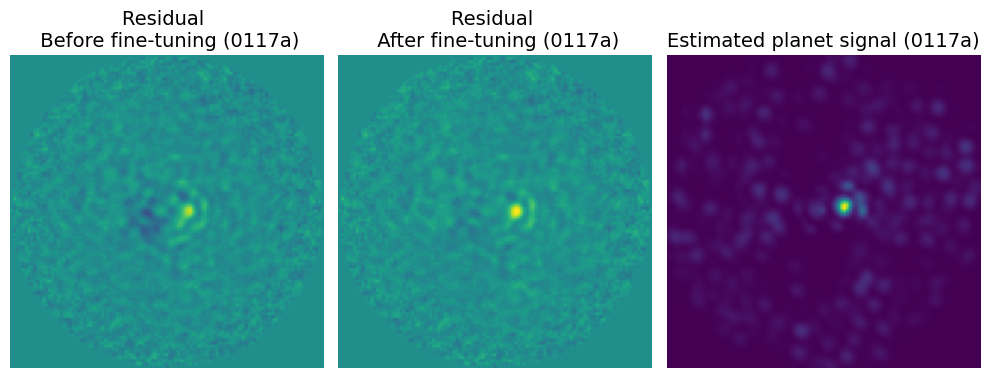

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))

limit = 0.05
fake_planet_id = config_file[-10:-5]

ax1.imshow(residual_before_fine_tuning,
           vmin=-limit, vmax=limit)
ax1.set_title(
    "Residual \n Before fine-tuning (" + fake_planet_id + ")",
    fontsize=14)
ax1.axis("off")

ax2.imshow(residual_after_fine_tuning,
           vmin=-limit, vmax=limit)
ax2.set_title(
    "Residual \n After fine-tuning (" + fake_planet_id + ")",
    fontsize=14)
ax2.axis("off")


ax3.imshow((planet_signal / X_std).cpu().detach().numpy()[-1, 0])

ax3.set_title(
    "Estimated planet signal (" + fake_planet_id + ")",
    fontsize=14)
ax3.axis("off")

plt.tight_layout()
plt.savefig("Fine_tuning_" + fake_planet_id + ".pdf")

In [70]:
save_as_fits(
    residual_before_fine_tuning,
    fake_planet_id + "_before_fine_tune.fits"
)

save_as_fits(
    residual_after_fine_tuning,
    fake_planet_id + "_after_fine_tune.fits"
)

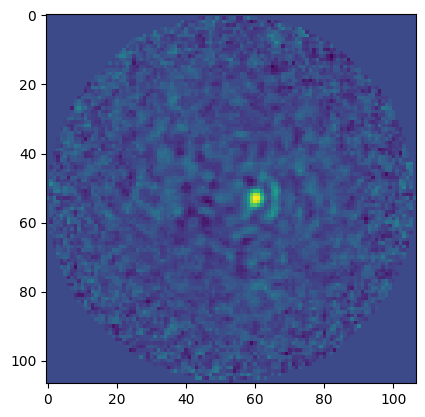

In [248]:
plt.imshow(residual_after_fine_tuning)

# OLD FINE-Tuning code with mean update

In [ ]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    
    # 1.) Get the current planet signal estimate
    planet_signal = s4_planet_model.forward(planet_model_idx)
    
    # 2.) Get the current data without the planet
    data_no_planet = science_data_torch - planet_signal.squeeze().detach()
    
    # 3.) Setup the normalization
    X_mu = torch.mean(data_no_planet, axis=0)
    X_std = torch.std(data_no_planet, axis=0)
    
    # 4.) get the current normalized data
    X_norm = (science_data_torch - X_mu) / X_std
    planet_signal_norm = planet_signal / X_std
    
    # 5.) reshape everything 
    planet_signal_norm = planet_signal_norm.view(
        science_data_torch.shape[0], -1)
    science_norm_flatten = X_norm.view(
        X_norm.shape[0], -1)
    
    # 6.) run the forward path
    P_hat_N = s4_noise(planet_signal_norm)
    P_hat_N[P_hat_N>0] = 0
    
    noise_estimate = s4_noise(science_norm_flatten) - P_hat_N

    # 7.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm
    
    # 8.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    loss_reg = (s4_noise.betas_raw**2).mean()

    # 9.) Backward 
    loss = loss_recon + loss_reg * s4_noise.lambda_reg
    loss.backward()

    optimizer.step()

    # 10.) Print the loss terms
    losses_recon.append(loss_recon.item())
    print(loss_recon.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = s4_planet_model.get_planet_signal() / X_std.detach()
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()